In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, sys
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor.tensor as pt

# sys.path.append('../src/')
## append parent to src path:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src')))
from dataloadermaker import DataLoaderMaker
import vis_utils as vu
import probabilistic_utils as pu

In [3]:
VeluweTreeData = DataLoaderMaker()
VeluweTreeData.load()
VeluweTreeData.makeBudBurstDataset()
VeluweTreeData.makeSpatioTemporalDataset()

# Get the budburst and temperature dataframe
temp_df = VeluweTreeData.get("temp_climwin_input")
budburst_df = VeluweTreeData.get("interpolated")

/home/thijs/repos/VeluweProtoDT/Py/src/dataloadermaker.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crown["BudBurstDate"] = pd.to_datetime(crown["BudBurstDate"])
/home/thijs/repos/VeluweProtoDT/Py/src/dataloadermaker.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crown["DOY"] = crown["BudBurstDate"].dt.dayofyear


(<Figure size 2000x400 with 2 Axes>,
 <Axes: xlabel='Year', ylabel='Budburst DOY'>,
 <Axes: xlabel='year_decimal', ylabel='Temperature (C)'>)

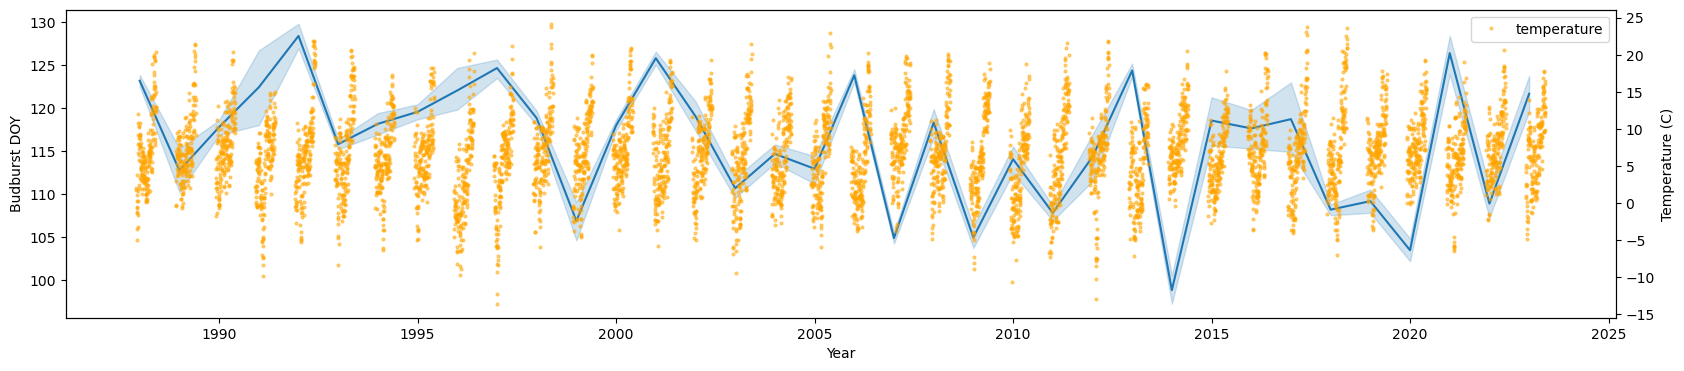

In [6]:
vu.plot_full_timeseries(budburst_df=budburst_df, temp_df=temp_df)

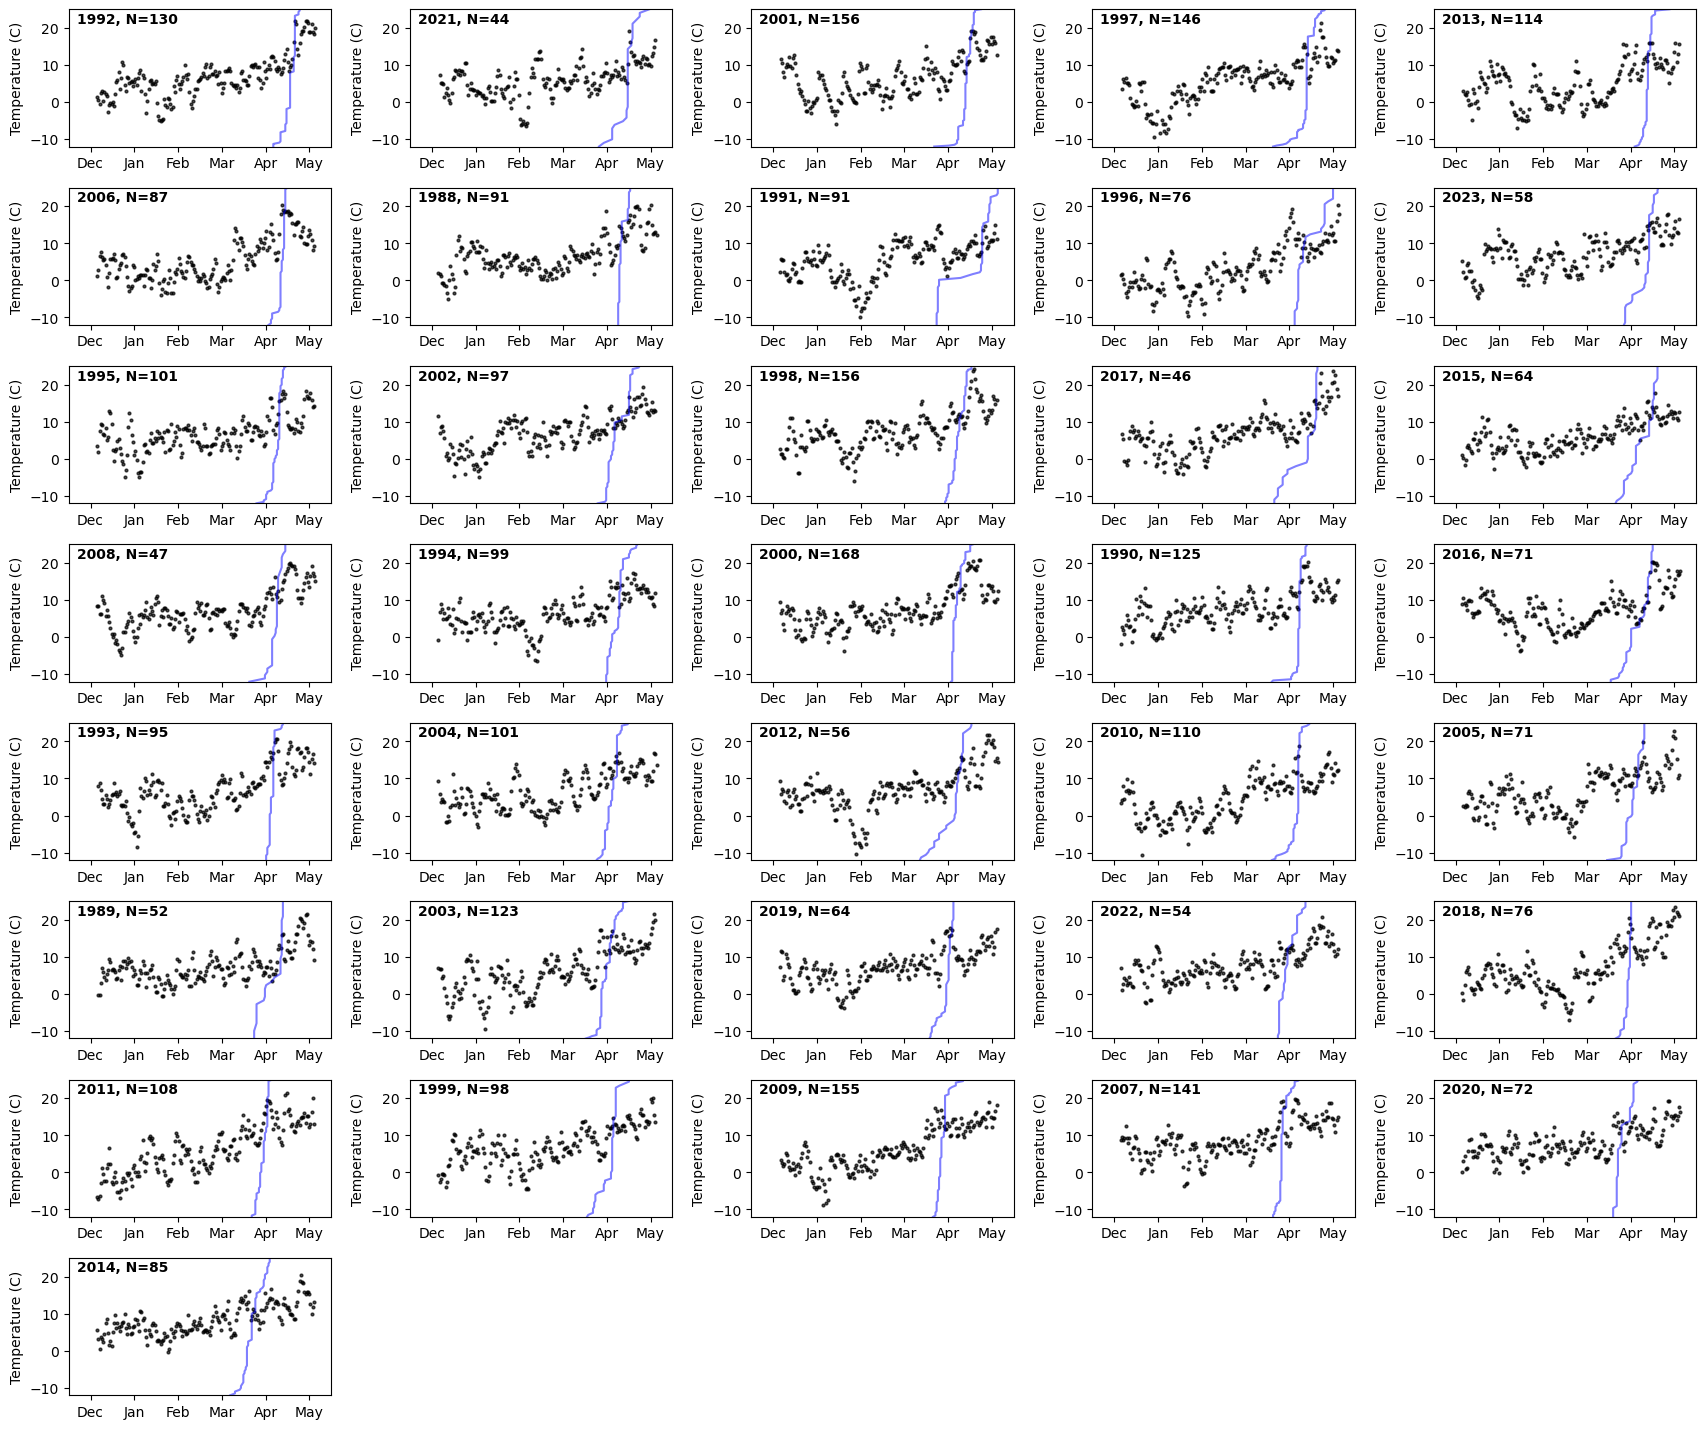

In [7]:
_ = vu.plot_bb_all_years(budburst_df=budburst_df, temp_df=temp_df, sort_by_bb_doy=True)

<Axes: xlabel='species'>

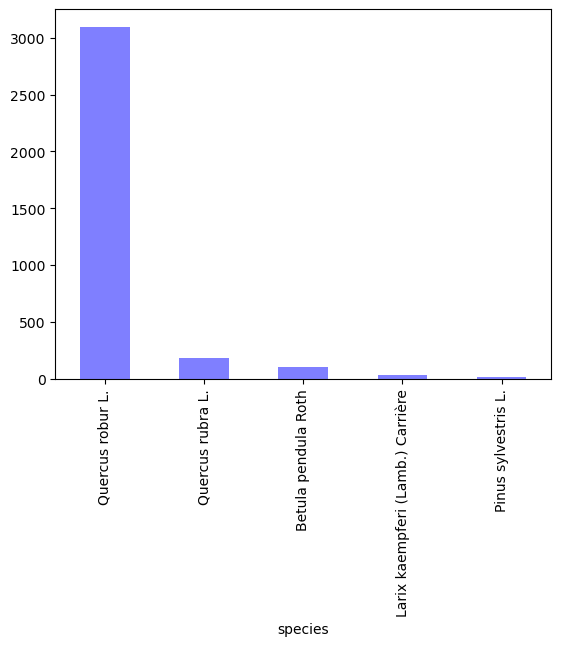

In [199]:
## count n obs per species
df_bb_mini['species'].value_counts().plot(kind='bar', color='blue', alpha=0.5)

In [ ]:
df_regression = pu.prep_data_for_regression(budburst_df=budburst_df, temp_df=temp_df,
                                            gdd_month_day_start=(2, 1), t_base=5)


,bb_cdf,date,temperature,gdd,season
0,0.0,1987-12-01 00:00:00+00:00,2.036997,0.000000,1987-1988
1,0.0,1987-12-02 00:00:00+00:00,1.764124,0.000000,1987-1988
2,0.0,1987-12-03 00:00:00+00:00,1.126213,0.000000,1987-1988
3,0.0,1987-12-04 00:00:00+00:00,-0.597208,0.000000,1987-1988
4,0.0,1987-12-05 00:00:00+00:00,-0.668622,0.000000,1987-1988
...,...,...,...,...,...
6556,1.0,2023-05-27 00:00:00+00:00,14.216854,446.540241,2022-2023
6557,1.0,2023-05-28 00:00:00+00:00,16.112461,457.652701,2022-2023
6558,1.0,2023-05-29 00:00:00+00:00,12.913763,465.566464,2022-2023
6559,1.0,2023-05-30 00:00:00+00:00,12.912954,473.479419,2022-2023


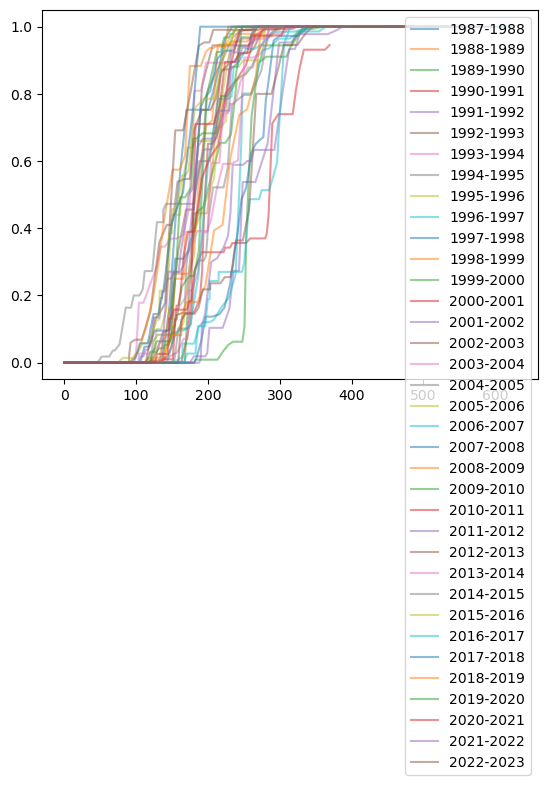

In [ ]:

ax = plt.subplot(111)
for i_s, s in enumerate(df_regression.season.unique()):
    if i_s == 100:
            break
    tmp_sel = df_regression[df_regression['season'] == s]
    
    ax.plot(tmp_sel['gdd'], tmp_sel['bb_cdf'],  alpha=0.5, label=s)
ax.legend();

In [12]:

# with pm.Model() as model:
#     t_base = pm.Normal("t_base", mu=5, sigma=2)  # Prior for base temperature
#     start_doy = pm.DiscreteUniform("start_date", lower=30, upper=60)  # Prior for GDD start date
#     ## convert start_doy to month and day
#     start_month = pm.math.floor(start_doy / 30)
#     start_day = start_doy - start_month * 30


#     tmp = pu.prep_data_for_regression(budburst_df=budburst_df, temp_df=temp_df,
#                                       t_base=t_base,
#                                     gdd_month_day_start=(start_month, start_day))



In [ ]:
df_regression = pu.prep_data_for_regression(budburst_df=budburst_df, temp_df=temp_df,
                                            gdd_month_day_start=(1, 1), t_base=5)
df_regression['doy'] = df_regression['date'].dt.day_of_year
df_regression = df_regression[df_regression['date'].dt.month < 7]  # delete Dec effectively, just to make DOY prior easier to deal with 
del df_regression['gdd']  ## delete gdd, we will use the gdd from the model

with pm.Model() as model:
    t_base = pm.Normal("t_base", mu=5, sigma=2)  # Prior for base temperature
    start_doy = pm.DiscreteUniform("start_date", lower=30, upper=90)  # Prior for GDD start date

    bb_cdf_obs = df_regression['bb_cdf'].values
    temperature = df_regression['temperature'].values

    t_above_base = pm.math.maximum(0, temperature - t_base)  # GDD calculation
    gdd = pm.math.zeros_like(t_above_base)  # Initialize GDD array
    for s in df_regression['season'].unique():
        inds_s = df_regression['season'] == s
        inds_s = inds_s.values

        # Calculate GDD for the current season
        doy_s = df_regression['doy'][inds_s].values
        gdd_s = t_above_base[inds_s]
        inds_before_start = doy_s < start_doy
        # gdd_s[inds_before_start] = 0  # Set GDD to 0 before start date
        # gdd_s = gdd_s.cumsum()
        # gdd[inds_s] = gdd_s
        gdd_s = pt.where(doy_s < start_doy, 0, gdd_s)
        gdd_s = pt.cumsum(gdd_s)
        gdd = pt.set_subtensor(gdd[inds_s], gdd_s)  # Alternative if gdd is also a tensor

    # Logistic function: maps GDD to cumulative fraction
    α = pm.Normal("α", mu=0, sigma=10)  # Intercept
    β = pm.Normal("β", mu=1, sigma=10)  # Slope
    μ = pm.Deterministic("mu", pm.math.sigmoid(α + β * gdd))  # Sigmoid function
    
    # Likelihood: Normal distribution with uncertainty
    σ = pm.HalfNormal("σ", sigma=0.1)
    bb_cdf_likelihood = pm.Normal("bb_cdf", mu=μ, sigma=σ, observed=bb_cdf_obs)

    # Sample posterior
    trace = pm.sample(200, return_inferencedata=True)


In [ ]:
df_regression = pu.prep_data_for_regression(budburst_df=budburst_df, temp_df=temp_df,
                                            gdd_month_day_start=(1, 1), t_base=5)
df_regression['doy'] = df_regression['date'].dt.day_of_year
df_regression = df_regression[df_regression['date'].dt.month < 7]  # delete Dec effectively, just to make DOY prior easier to deal with 
del df_regression['gdd']  ## delete gdd, we will use the gdd from the model
seasons = df_regression["season"].unique()
n_seasons_train = 30
print(f"Number of seasons: {len(seasons)}, training seasons: {n_seasons_train}")
train_seasons = seasons[:n_seasons_train]  
test_seasons = seasons[n_seasons_train:]  

df_train = df_regression[df_regression["season"].isin(train_seasons)]
df_test = df_regression[df_regression["season"].isin(test_seasons)]


with pm.Model() as model:
    t_base = pm.Normal("t_base", mu=5, sigma=2)  # Prior for base temperature
    start_doy = pm.DiscreteUniform("start_date", lower=30, upper=120)  # Prior for GDD start date

    bb_cdf_obs = df_train['bb_cdf'].values
    temperature = df_train['temperature'].values

    t_above_base = pm.math.maximum(0, temperature - t_base)  # GDD calculation
    gdd = pm.math.zeros_like(t_above_base)  # Initialize GDD array
    for s in df_train['season'].unique():
        inds_s = df_train['season'] == s
        inds_s = inds_s.values

        # Calculate GDD for the current season
        doy_s = df_train['doy'][inds_s].values
        gdd_s = t_above_base[inds_s]
        # gdd_s[doy_s < start_doy] = 0  # Set GDD to 0 before start date
        # gdd_s = gdd_s.cumsum()
        # gdd[inds_s] = gdd_s
        gdd_s = pt.where(doy_s < start_doy, 0, gdd_s)
        gdd_s = pt.cumsum(gdd_s)
        gdd = pt.set_subtensor(gdd[inds_s], gdd_s)  # Alternative if gdd is also a tensor

    # Logistic function: maps GDD to cumulative fraction
    α = pm.Normal("α", mu=0, sigma=10)  # Intercept
    β = pm.Normal("β", mu=1, sigma=10)  # Slope
    μ = pm.Deterministic("mu", pm.math.sigmoid(α + β * gdd))  # Sigmoid function
    
    # Likelihood: Normal distribution with uncertainty
    σ = pm.HalfNormal("σ", sigma=0.1)
    bb_cdf_likelihood = pm.Normal("bb_cdf", mu=μ, sigma=σ, observed=bb_cdf_obs)

    # Sample posterior
    trace = pm.sample(500, return_inferencedata=True)


Number of seasons: 36, training seasons: 30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [t_base, α, β, σ]
>Metropolis: [start_date]


Output()

/home/thijs/anaconda3/envs/protodt/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/thijs/anaconda3/envs/protodt/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/home/thijs/anaconda3/envs/protodt/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/thijs/anaconda3/envs/protodt/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 208 seconds.
/home/thijs/anaconda3/envs/protodt/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [25]:
## print size of gdd and bb_cdf_obs
print("gdd size: ", temperature.shape)
print("bb_cdf_obs size: ", bb_cdf_obs.shape)

trace

gdd size:  (4538,)
bb_cdf_obs size:  (4538,)


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

<Axes: xlabel='t_base', ylabel='start_date'>

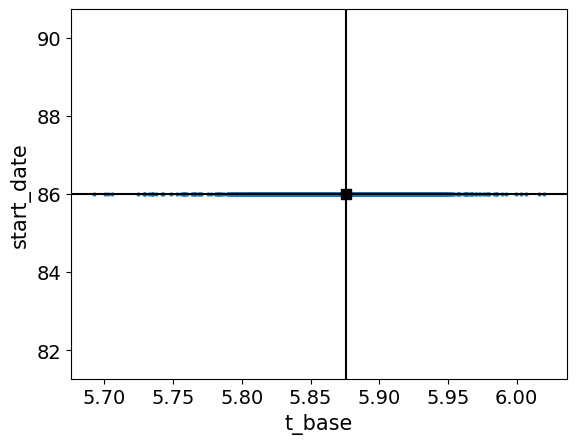

In [76]:
# az.plot_forest(trace, var_names=["t_base", "start_date", "α", "β", "σ"], combined=True)

## plot joint posterior of t_base and start_date    

az.plot_pair(trace, var_names=["t_base", "start_date"], kind="scatter", point_estimate="mean")

R² on test set: 0.936


/tmp/ipykernel_144425/1644215779.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["predicted_bb_cdf"] = mu_test


Text(0, 0.5, 'Predicted BB CDF')

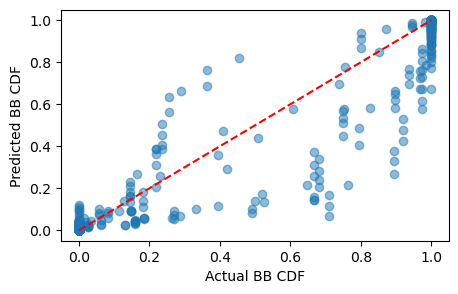

In [74]:

# Get posterior samples
posterior = az.extract(trace)

method_estimate = 'mean'
match method_estimate:
    case 'mean':
        t_base_post = float(posterior["t_base"].mean().values)  # or az.map_estimate(trace)["t_base"]
        start_doy_post = float(posterior["start_date"].mean().values)  # or MAP estimate
    case 'median':
        t_base_post = float(posterior["t_base"].median().values)  # or az.map_estimate(trace)["t_base"]
        start_doy_post = float(posterior["start_date"].median().values)  # or MAP estimate
    # case 'MAP':
        # t_base_post = az.map_estimate(trace)["t_base"]
        # start_doy_post = az.map_estimate(trace)["start_date"]

# Compute GDD for test data
temperature_test = df_test["temperature"].values
t_above_base_test = np.maximum(0, temperature_test - t_base_post)

gdd_test = np.zeros_like(t_above_base_test)
for s in df_test["season"].unique():
    inds_s = df_test["season"] == s
    inds_s = inds_s.values

    doy_s = df_test["doy"][inds_s].values
    gdd_s = t_above_base_test[inds_s]
    gdd_s[doy_s < start_doy_post] = 0
    gdd_s = np.cumsum(gdd_s)
    gdd_test[inds_s] = gdd_s

α_post = float(posterior["α"].mean().values)  # or MAP estimate
β_post = float(posterior["β"].mean().values)  # or MAP estimate

mu_test = 1 / (1 + np.exp(-(α_post + β_post * gdd_test)))  # Sigmoid function

# Compare to actual values
df_test["predicted_bb_cdf"] = mu_test

# Compute R² or other metrics
from sklearn.metrics import r2_score
r2 = r2_score(df_test["bb_cdf"], df_test["predicted_bb_cdf"])
print(f"R² on test set: {r2:.3f}")

# Plot predictions vs actual values
plt.figure(figsize=(5, 3))
plt.scatter(df_test["bb_cdf"], df_test["predicted_bb_cdf"], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual BB CDF") 
plt.ylabel("Predicted BB CDF")

<Axes: title={'center': 'start_date'}>

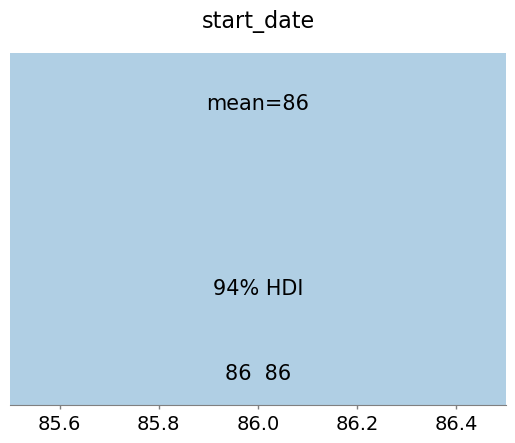

In [69]:
az.plot_posterior(trace, var_names=["start_date"])

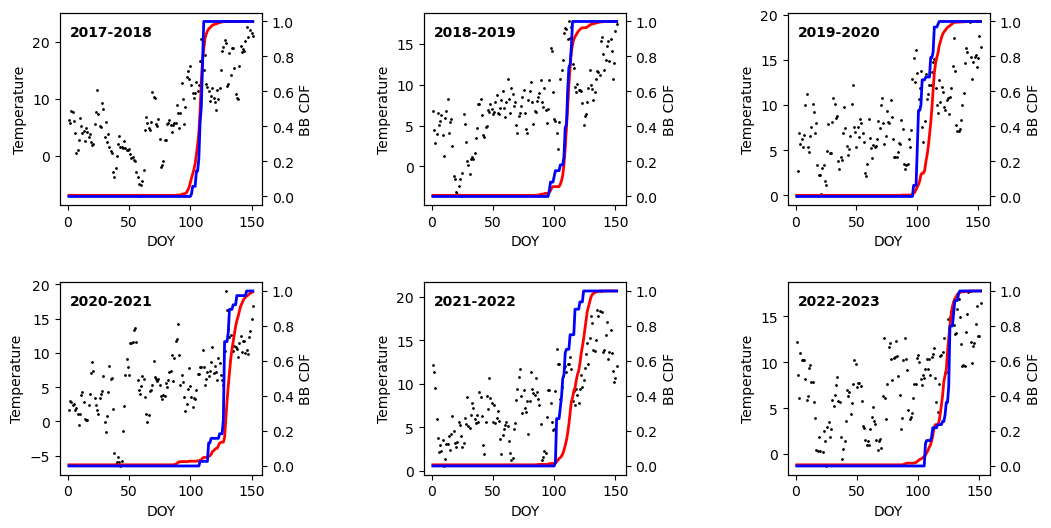

In [57]:
fig, ax = plt.subplots(figsize=(12, 6), nrows=2, ncols=3, gridspec_kw={"hspace": 0.4, "wspace": 0.8})

for i_s, s in enumerate(df_test['season'].unique()):
    tmp_sel = df_test[df_test['season'] == s]
    curr_ax = np.ravel(ax)[i_s]

    curr_ax.plot(tmp_sel.doy, tmp_sel.temperature, '.', c='k', markersize=2)

    ax2 = curr_ax.twinx()
    ax2.plot(tmp_sel.doy, tmp_sel.predicted_bb_cdf, 'r-', lw=2)
    ax2.plot(tmp_sel.doy, tmp_sel.bb_cdf, 'b-', lw=2)
    curr_ax.annotate(s, xy=(0.05, 0.9), xycoords='axes fraction', ha='left', va='center', weight='bold')
    curr_ax.set_xlabel("DOY")
    curr_ax.set_ylabel("Temperature")
    ax2.set_ylabel("BB CDF")

/tmp/ipykernel_144425/3839216515.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["predicted_bb_cdf"] = bb_cdf_mean
/tmp/ipykernel_144425/3839216515.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["bb_cdf_lower"] = bb_cdf_lower
/tmp/ipykernel_144425/3839216515.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

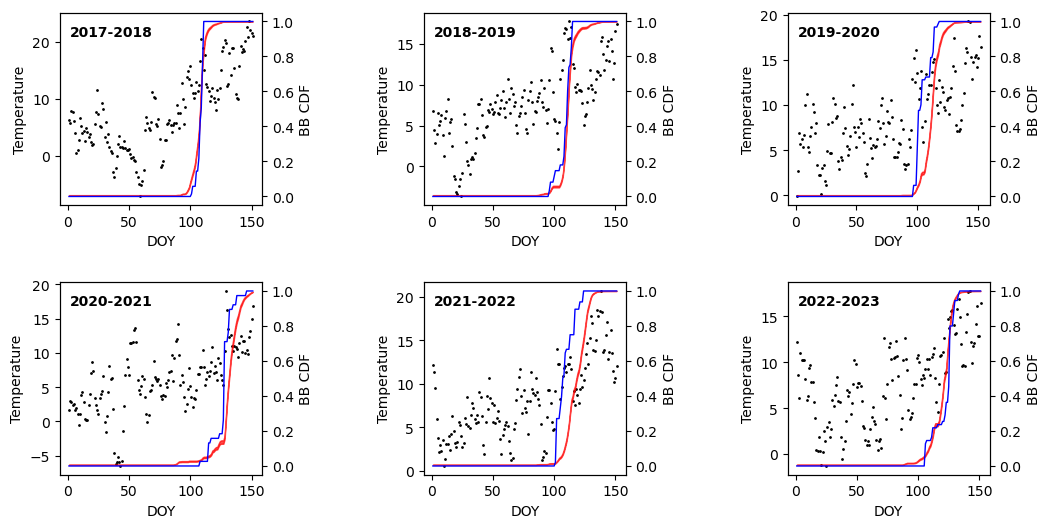

In [78]:
# Extract posterior samples (e.g., 1000 samples)
posterior_samples = az.extract(trace)
n_samples = len(posterior_samples["t_base"])  # Number of posterior samples

temperature_test = df_test["temperature"].values
n_test = len(temperature_test)  # Number of test observations

# Initialize array to store GDD predictions (n_samples x n_test)
gdd_samples = np.zeros((n_samples, n_test))

for i in range(n_samples):
    t_base_sample = float(posterior_samples["t_base"][i].values)
    start_doy_sample = float(posterior_samples["start_date"][i].values)

    t_above_base_test = np.maximum(0, temperature_test - t_base_sample)

    gdd_test = np.zeros_like(t_above_base_test)
    for s in df_test["season"].unique():
        inds_s = df_test["season"] == s
        inds_s = inds_s.values

        doy_s = df_test["doy"][inds_s].values
        gdd_s = t_above_base_test[inds_s]
        gdd_s[doy_s < start_doy_sample] = 0  # Set GDD to 0 before start date
        gdd_s = np.cumsum(gdd_s)  # Compute cumulative sum
        gdd_test[inds_s] = gdd_s

    gdd_samples[i, :] = gdd_test  # Store sample-specific GDD

# Initialize array for predictions (n_samples x n_test)
bb_cdf_samples = np.zeros((n_samples, n_test))

for i in range(n_samples):
    α_sample = float(posterior_samples["α"][i].values)
    β_sample = float(posterior_samples["β"][i].values)
    
    # Logistic function: maps GDD to cumulative fraction
    bb_cdf_samples[i, :] = 1 / (1 + np.exp(-(α_sample + β_sample * gdd_samples[i, :])))

bb_cdf_mean = np.mean(bb_cdf_samples, axis=0)  # Mean prediction
bb_cdf_lower = np.percentile(bb_cdf_samples, 0.5, axis=0)  # 2.5th percentile (lower CI)
bb_cdf_upper = np.percentile(bb_cdf_samples, 99.5, axis=0)  # 97.5th percentile (upper CI)

df_test["predicted_bb_cdf"] = bb_cdf_mean
df_test["bb_cdf_lower"] = bb_cdf_lower
df_test["bb_cdf_upper"] = bb_cdf_upper


# Plot predictions with uncertainty (shaded area)
fig, ax = plt.subplots(figsize=(12, 6), nrows=2, ncols=3, gridspec_kw={"hspace": 0.4, "wspace": 0.8})

for i_s, s in enumerate(df_test['season'].unique()):
    tmp_sel = df_test[df_test['season'] == s]
    curr_ax = np.ravel(ax)[i_s]

    curr_ax.plot(tmp_sel.doy, tmp_sel.temperature, '.', c='k', markersize=2)

    ax2 = curr_ax.twinx()
    # ax2.plot(tmp_sel.doy, tmp_sel.predicted_bb_cdf, 'r-', lw=2)
    ax2.plot(tmp_sel.doy, tmp_sel.bb_cdf, 'b-', lw=1)
    ## uncertainty:
    ax2.fill_between(x=tmp_sel.doy, y1=tmp_sel.bb_cdf_lower, y2=tmp_sel.bb_cdf_upper, color='red', alpha=0.7)


    curr_ax.annotate(s, xy=(0.05, 0.9), xycoords='axes fraction', ha='left', va='center', weight='bold')
    curr_ax.set_xlabel("DOY")
    curr_ax.set_ylabel("Temperature")
    ax2.set_ylabel("BB CDF")

In [63]:
df_test

,bb_cdf,date,temperature,season,doy,predicted_bb_cdf,bb_cdf_lower,bb_cdf_upper
5499,0.0,2018-01-01 00:00:00+00:00,6.375380,2017-2018,1,0.006641,0.005870,0.007451
5500,0.0,2018-01-02 00:00:00+00:00,5.831709,2017-2018,2,0.006641,0.005870,0.007451
5501,0.0,2018-01-03 00:00:00+00:00,7.937914,2017-2018,3,0.006641,0.005870,0.007451
5502,0.0,2018-01-04 00:00:00+00:00,7.693305,2017-2018,4,0.006641,0.005870,0.007451
5503,0.0,2018-01-05 00:00:00+00:00,6.115874,2017-2018,5,0.006641,0.005870,0.007451
...,...,...,...,...,...,...,...,...
6556,1.0,2023-05-27 00:00:00+00:00,14.216854,2022-2023,147,0.999874,0.999841,0.999901
6557,1.0,2023-05-28 00:00:00+00:00,16.112461,2022-2023,148,0.999922,0.999901,0.999940
6558,1.0,2023-05-29 00:00:00+00:00,12.913763,2022-2023,149,0.999944,0.999928,0.999957
6559,1.0,2023-05-30 00:00:00+00:00,12.912954,2022-2023,150,0.999960,0.999948,0.999969
